In [1]:
import seaborn as sns
sns.set()

In [7]:
import quandl
import dill
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import matplotlib.pyplot as plt
from ipywidgets import interact

# Time Series
<!-- requirement: images/ts_xval.png -->
<!-- requirement: projects/timeseries-project -->
<!-- requirement: small_data/quandl_oil.pkl -->
<!-- requirement: small_data/quandl_ng_fut.pkl -->


Time series prediction or forecasting presents its own challenges which are different from machine-learning problems.  Like many other classes of problems, it also presents a number of special features which are common.

In general, while we could use regression to make predictions, the goal of time series analysis is to take advantage of the temporal nature of the data to make more sophisticated models. To properly forecast events, we need to implement techniques to find and model the long term trends (**drift**), periodic signals (**seasonality**), and residual noise in our data. We will also need to preserve the order of our observations while cross-validating our model.

We will follow this general procedure for modeling time series:
1. Plot the time series. Look for trends, seasonality, and step changes.
2. Model and remove drift and seasonal components. 
3. Fit a model to the residuals. 
4. Add drift and seasonality back into the model. 


## Trends in time series data


As we explain these, let's first define our time-series as

$$ \{X_t, t = \ldots, -1, 0, 1, \ldots\} \, . $$

We take $\varepsilon \sim N(0, \sigma^2)$ to be i.i.d. normal errors.  
1. **Stationarity**.  Informally, this means that the distribution of the $X_t$ is independent of time $t$.  Formally, a time-series is stationary if for all $k \ge 0$ and $t$, the following two $k$-tuples have the same distribution:
$$ (X_0,\ldots,X_k) \sim (X_t,\ldots,X_{t+k}) $$
1. **Drift**.  One reason a time-series might not be stationary is that it possess a drift.  For example, we know that prices tend to creep up with inflation.  Mathematically, we might represent the (log) prices as
$$ X_t = \mu t + \varepsilon_t $$
1. **Seasonality**.  Another reason a time-series might not be stationary is that it possesses a seasonal component.  For example, we know that the temperature increases in the summer and decreases in the winter.  A simple model of this might be
$$ X_t = \alpha \sin(\omega t) + \beta \cos(\omega t)$$

## Cross-validation for time series

Cross validation is very different for time series than with other machine-learning problem classes.  In normal machine-learning, we select a random subset of data as a validation set to estimate accuracy of your measure.  In time series, we have to consider the problem that we are trying to solve is often to predict a value in the future.  Therefore, the validation data always has to occur *after* the training data.  As a simple example, consider that it would not be very useful to have a predictor of tomorrow's temperature that depended on the temperature the day after. In general:

- We cannot just pick data points at random, because there might be lagged indicators / seasonal effects / etc. that force us to work with contiguous blocks of time.  
- We cannot blindly chop by e.g., month or year without some thought: There could be seasonal effects so that Decembers are always different.  There could be systemic "regime changes" that mean that cutting at a given date is inappropriate, or known and time-limited effects that last a year (or fraction thereof).   For instance, the years 1991 and 2008 in this data set.
- We cannot have our testing set occur before our training set.

![ts cross-validation illustration](images/ts_xval.png)

We usually handle this by doing a **sliding-window validation method**.  That is, we train on the last $n$ data points and validate the prediction on the next $m$ data points, sliding the $n + m$ training / validation window in time.  In this way, we can estimate the parameters of our model.  To test the validity of the model, we might use a block of data at the end of our time series which is reserved for testing the model with the learned parameters.

Another common technique is to use [**forward chaining**](http://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection).

**Question:** What are the strengths and weaknesses of using a fixed vs. rolling window?

## Modeling drift


For examples, we will use two different data sets, weather and oil prices. The weather data is available locally in the `projects/` subdirectory, and the oil data retrieved from __[Quandl](https://www.quandl.com/)__.  Quandl is a website that has lots of financial data available (and some other data sets), such as stock prices and oil prices (as we are using here).  A lot of Quandl's data is available for free, you just need to get an authorization token to download it (after registering on the website).  

In [9]:
# To properly use the Quandl API, you should get an authtoken.  Very limited usage doesn't require it.

# authtoken = None
authtoken = "HSm5uz-kdzQgsbYBU-zS"

def get_quandl(what, authtoken=None):
    """ 
    Wrapper around Quandl requests, using authtoken only if available
    """
    if authtoken:
        return quandl.get(what, authtoken=authtoken)
    else:
        return quandl.get(what)
    
oil = get_quandl("EIA/PET_RWTC_D", authtoken)  #  This would require an API authtoken to get the full set of data.  

In [10]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8809 entries, 1986-01-02 to 2020-11-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   8809 non-null   float64
dtypes: float64(1)
memory usage: 137.6 KB


In [11]:
with open('small_data/quandl_oil.pkl', 'wb') as f:
    dill.dump(oil, f)

In [22]:
#  We will use data that was previously retrieved from Quandl.
with open("small_data/quandl_oil.pkl", "rb") as fin:
    oil = dill.load(fin)

We will start of by visually inspecting our time series. 

In [23]:
oil.head()

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [24]:
oil.sort_values('Value').head()

,Value
Date,
2020-04-20,-36.98
2020-04-21,8.91
1986-03-31,10.25
1998-12-10,10.82
1986-07-25,10.83


In [35]:
oil = oil.drop(np.datetime64('2020-04-20'))

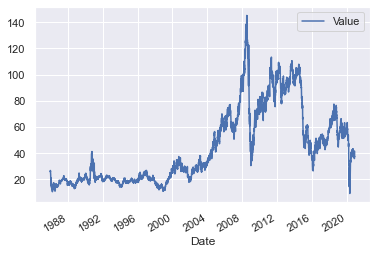

In [36]:
oil.plot();

Looking at the plot of oil value over time, we see that the trend is exponential. We can model exponential trends using a linear regression model if we transform the data first. 

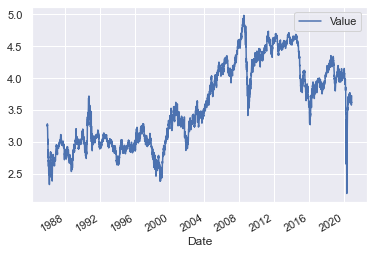

In [37]:
np.log(oil).plot();

In [38]:
# Add a constant field for the linear regression
def add_constant(X):
    X['const'] = pd.Series(np.ones(len(X.index)), index=X.index)
    return X

In [39]:
oil['Julian'] = oil.index.to_julian_date()
oil = add_constant(oil) 

oil.head()

,Value,Julian,const
Date,,,
1986-01-02,25.56,2446432.5,1.0
1986-01-03,26.00,2446433.5,1.0
1986-01-06,26.53,2446436.5,1.0
1986-01-07,25.85,2446437.5,1.0
1986-01-08,25.87,2446438.5,1.0


In [40]:
# We can actually train a simple exponential model using the log(value), then train further models on the error.
exponential_model = sklearn.linear_model.Ridge().fit( 
    X=oil[['Julian', 'const']], 
    y=np.log(oil['Value'])
)

exponential_model

Ridge()

In [41]:
exp_model_df = oil
exp_model_df['Exponential_Model'] = np.exp(exponential_model.predict(oil[['Julian', 'const']]))
exp_model_df['Log_Error_Exponential'] = np.log(oil['Value'] / oil['Exponential_Model'])

exp_model_df.head()

,Value,Julian,const,Exponential_Model,Log_Error_Exponential
Date,,,,,
1986-01-02,25.56,2446432.5,1.0,14.660441,0.555876
1986-01-03,26.00,2446433.5,1.0,14.662491,0.572804
1986-01-06,26.53,2446436.5,1.0,14.668642,0.592564
1986-01-07,25.85,2446437.5,1.0,14.670693,0.566459
1986-01-08,25.87,2446438.5,1.0,14.672745,0.567092


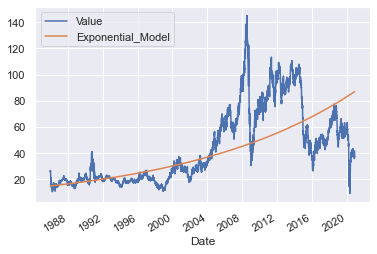

In [42]:
exp_model_df[['Value', 'Exponential_Model']].plot();

## Modeling seasonality


Let's take a look at the temperature data set and see if we can spot any periodic signals. 

In [43]:
import datetime
temps = pd.read_csv("projects/timeseries-project/data/raw/temperatures.csv", 
                    index_col=0,
                    names=["Temperature"],
                    parse_dates=True,
                    date_parser=lambda u: datetime.datetime.strptime(u, "%Y-%m-%d %H:%M:%S"))

In [44]:
temps.head()

,Temperature
2001-01-01 00:00:00,18
2001-01-01 01:00:00,18
2001-01-01 02:00:00,17
2001-01-01 03:00:00,20
2001-01-01 04:00:00,21


In [45]:
temps = temps.asfreq('60Min', method='ffill')
# print(temps[:3])

temps.head()

,Temperature
2001-01-01 00:00:00,18
2001-01-01 01:00:00,18
2001-01-01 02:00:00,17
2001-01-01 03:00:00,20
2001-01-01 04:00:00,21


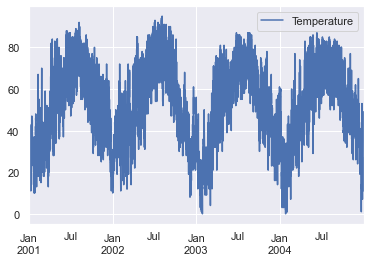

In [46]:
# Let's plot a few years of data 
temps[:365*24*4].plot();

We can clearly see that there is seasonality in our temperature data. In order to model or remove these signals from our time series, we need to determine their amplitudes and frequencies. Since we are all familiar with daily and yearly temperature swings, we can probably guess what those frequencies are. However, there is a formal approach we can take to find these frequencies. 

### Fourier Analysis


Any periodic signal can be represented as the sum of a number of sine waves with varying amplitude, phase, and frequency.  A time series can be converted into its frequency components with the mathematical tool known as the *Fourier transform*.  As we are dealing with sampled data, we must use the discrete version.  

For $N$ uniformly sampled data points $x_j$ ($j = 0$,...,$N-1$)

$$ x_j = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{i2 \pi jk/N} $$
$$ X_k = \sum_{j=0}^{N-1} x_j e^{-i2 \pi jk/N} $$

The common algorithm for computing discrete transforms is the *fast Fourier transform*, usually abbreviated *FFT*.

The output of a FFT can be thought of as a representation of all the frequency components of your data. In some sense it is a histogram with each “frequency bin” corresponding to a particular frequency in your signal. Each frequency component has both an amplitude and phase, and is represented as a complex number. In the equations above, $X_k$ can be thought of as the "amount" of frequency $k$ in the signal $x$. Generally, we care only about the amplitude, given by the modulus of that complex term.  As we are dealing with discrete data, the signal is bounded, and interpretation of the axes requires some consideration.

For our purposes, it's enough to know that any strong signals such as peaks in the frequency domain represent some periodic (sinusoidal) behavior in the time domain. You can then go through the process of determining the wavelength (periodicity) based on how the FFT was taken.

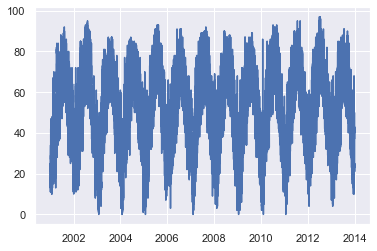

In [47]:
plt.plot(temps.Temperature)

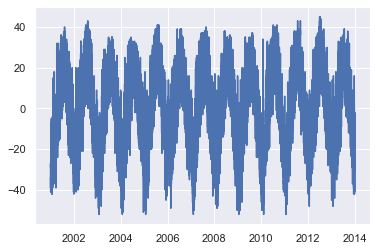

In [48]:
plt.plot(temps.Temperature - temps.Temperature.mean())

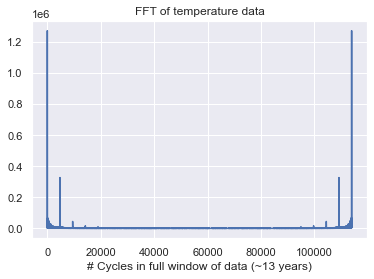

In [49]:
import scipy.fft

fft = scipy.fft.fft((temps.Temperature - temps.Temperature.mean()).values)
plt.plot(np.abs(fft))
plt.title("FFT of temperature data")
plt.xlabel('# Cycles in full window of data (~13 years)');

Note that we subtract the mean before computing the FFT.  Otherwise, there would be a large zero-frequency component.

The x-axis is showing frequency.  Low frequencies, corresponding to long times, are on the left; high frequencies and short times are on the right.  The lowest non-zero frequency measured has a single cycle over the full 13-year period, corresponding to a frequency of $1/13\, y^{-1}$.  The highest frequency is that of the sampling, $1\, h^{-1}$.

The discrete Fourier transform of real data is symmetric about the center of its frequency range.  Due to the problem of *aliasing*, it cannot distinguish signals with a frequency above half its sampling frequency from those below.  This limiting frequency is called the **Nyquist frequency**, and the results of a FFT for frequencies above it should be ignored.

More formally, the Nyquist frequency is the highest frequency that can be resolved given your sampling rate.

$$ \nu_N = \frac{1}{2 \Delta t} $$

The following plot demonstrates that, with a sampling frequency of 1, it is impossible to distinguish between signals above and below the Nyquist frequency of 0.5.

In [50]:
def plot_alias(f=0.2):
    t = np.linspace(0, 10, 1000)
    ts = np.arange(0, 11)
    plt.plot(t, np.sin(2*np.pi * f * t), label='f = %0.2f' % f)
    plt.plot(t, -np.sin(2*np.pi * (1 - f) * t), label='f = %0.2f' % (1 - f))
    ml, sl, bl = plt.stem(ts, np.sin(2*np.pi * f * ts), label='Sampled signal', use_line_collection=True)
    plt.setp(ml, 'markerfacecolor', 'r')
    plt.setp(sl, 'color', 'r')
    plt.setp(bl, visible=False)
    plt.xticks(ts)
    plt.ylim(-2,2)
    plt.legend()

interact(plot_alias, f=(0,0.5,0.05));

interactive(children=(FloatSlider(value=0.2, description='f', max=0.5, step=0.05), Output()), _dom_classes=('w…

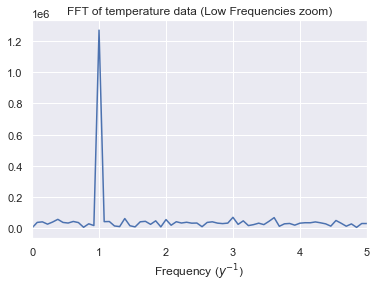

In [51]:
plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)');

**Question:** Is the above showing the yearly or daily seasonality?

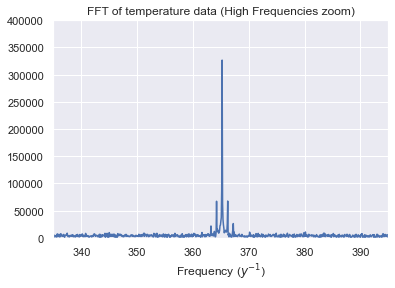

In [52]:
daily_cycles_in_13_years = 13*365

plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (High Frequencies zoom)")
plt.ylim([0,400000])
plt.xlim([365 - 30, 365 + 30])
plt.xlabel('Frequency ($y^{-1}$)');

**Question:** What do you expect the FFT of the oil data to look like?

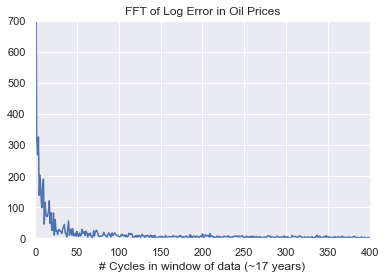

In [53]:
fft = scipy.fft.fft(oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2010)].values)
plt.plot(np.abs(fft))
plt.ylim([0, 700])
plt.xlim([0, 400])
plt.title('FFT of Log Error in Oil Prices')
plt.xlabel('# Cycles in window of data (~17 years)');

There are two ways to handle seasonality.  Seasonality features are nice because they are good at projecting arbitrarily far into the future.

1. The simplest (and perhaps most robust) is to have a set of indicator variables for each month.

  **Question**: Should month be a continuous or categorical variable?

1. Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be
$$ y_t = k \sin\left( \frac{t - t_0}{T} \right) + \epsilon$$
where $k$ and $t_0$ are parameters to be learned and $T$ is one year for seasonal variation.  While this is linear in $k$, it is not linear in $t_0$.  However, we know from Fourier analysis, that the above is equivalent to 
$$ y_t = A \sin\left( \frac{t}{T} \right) + B \cos\left( \frac{t}{T} \right) + \epsilon$$
which is linear in $A$ and $B$.  This can be solved using a linear regression.

**Question:** Does it always make sense to combine seasonal frequencies additively? When would it not?

### Example: Temperature data

Suppose we want to predict the temperature 24 hours from now.  How will we do this?  We model the seasonality of the data as mentioned above.  Let's use yearly frequencies, biannual frequencies, and daily frequencies in the model we build.  

In [54]:
temps['Julian'] = temps.index.to_julian_date()
temps['const'] = 1
temps['sin(year)'] = np.sin(temps['Julian'] / 365.25 * 2 * np.pi)
temps['cos(year)'] = np.cos(temps['Julian'] / 365.25 * 2 * np.pi)
temps['sin(6mo)'] = np.sin(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['cos(6mo)'] = np.cos(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['sin(day)'] = np.sin(temps.index.hour / 24.0 * 2* np.pi)
temps['cos(day)'] = np.cos(temps.index.hour / 24.0 * 2* np.pi)

In [56]:
temps.head()

,Temperature,Julian,const,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day)
2001-01-01 00:00:00,18,2.451910e+06,1,-0.217577,0.976043,-0.424728,0.905321,0.000000,1.000000
2001-01-01 01:00:00,18,2.451911e+06,1,-0.216877,0.976199,-0.423430,0.905929,0.258819,0.965926
2001-01-01 02:00:00,17,2.451911e+06,1,-0.216177,0.976354,-0.422131,0.906535,0.500000,0.866025
2001-01-01 03:00:00,20,2.451911e+06,1,-0.215477,0.976509,-0.420831,0.907139,0.707107,0.707107
2001-01-01 04:00:00,21,2.451911e+06,1,-0.214777,0.976663,-0.419530,0.907741,0.866025,0.500000


In [57]:
temps['Temperature'].head()

2001-01-01 00:00:00    18
2001-01-01 01:00:00    18
2001-01-01 02:00:00    17
2001-01-01 03:00:00    20
2001-01-01 04:00:00    21
Freq: 60T, Name: Temperature, dtype: int64

In [58]:
temps['Temperature'].shift(-1).head()

2001-01-01 00:00:00    18.0
2001-01-01 01:00:00    17.0
2001-01-01 02:00:00    20.0
2001-01-01 03:00:00    21.0
2001-01-01 04:00:00    21.0
Freq: 60T, Name: Temperature, dtype: float64

In [59]:
# Notice that the goal (what we want to predict) is our temperature variable shifted by the desired period of time.
temps['Goal'] = temps['Temperature'].shift(-24)

temps.head()

,Temperature,Julian,const,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day),Goal
2001-01-01 00:00:00,18,2.451910e+06,1,-0.217577,0.976043,-0.424728,0.905321,0.000000,1.000000,20.0
2001-01-01 01:00:00,18,2.451911e+06,1,-0.216877,0.976199,-0.423430,0.905929,0.258819,0.965926,20.0
2001-01-01 02:00:00,17,2.451911e+06,1,-0.216177,0.976354,-0.422131,0.906535,0.500000,0.866025,18.0
2001-01-01 03:00:00,20,2.451911e+06,1,-0.215477,0.976509,-0.420831,0.907139,0.707107,0.707107,18.0
2001-01-01 04:00:00,21,2.451911e+06,1,-0.214777,0.976663,-0.419530,0.907741,0.866025,0.500000,17.0


In [60]:
cut_year = 2012

train = temps[temps.index.year < cut_year].dropna(how='any')
test  = temps[temps.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

regress

LinearRegression()

60.461166926486975


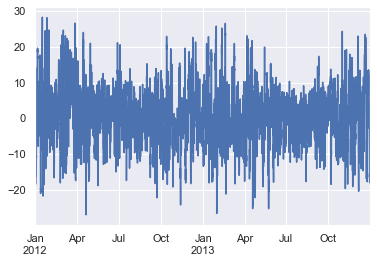

In [61]:
test['Predicted_Value'] = regress.predict(X=test[['Temperature', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()
print(sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value']))

To remove these frequencies, you can apply a filter to your time series. Filters are discussed in further detail in the digital signals notebook. You can also check out [this](http://stackoverflow.com/questions/39799821/how-to-remove-frequency-from-signal) stack overflow post. 

## Modeling "noise"


We can improve our temperature predictions by modeling the noise. In this context, the noise is caused by weather patterns that are superimposed on the background climatology. If you are trying to predict the temperature a few hours into the future (what is known as *nowcasting*), you can imagine that the weather from two months ago is not as good of an indicator as the weather from three hours ago. How far back in your time series should you look? You can autocorrelate your time series (with drift and seasonality removed) to find out.

### Autocorrelation


Let's review some definitions from statistics:

* **Covariance** ($s_{xy}$)

$$ \mbox{Cov}(X,Y) = E[(X - E(X))(Y - E(Y))] = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y}) $$

* **Variance** ($s_x^2$) is equal to $\mbox{Cov}(X,X)$.

$$ \mbox{Var}(X) = E[(X - E(X))^2] = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})^2 $$

* **Standard Deviation** ($s_x$) is the square root of the variance. 
* **Correlation** ($\rho$)

$$ \mbox{Cor}(X,Y) = \frac{s_{xy}}{s_x s_y} $$

If we replace time series Y with a lagged version of X, we can compute the autocovariance and autocorrelation of X at that given lag, $k$. 

* **Autocovariance**

$$ \gamma_k = \mbox{Cov}(X_t, X_{t+k}) $$

* **Autocorrelation**

$$ \rho_k = \frac{\gamma_k}{\gamma_0} = \frac{\gamma_k}{s_x^2}$$

**Question**: The definitions above apply to data sampled from some parent population. How do the equations change if you consider the entire population?

It is useful to plot the autocorrelation for different values of $k$. Pandas includes a function which will create an autocorrelation plot for any data series.  It includes lines showing the 95% (solid) and 99% (dashed) confidence levels of the zero-correlation hypothesis. Let's look at this plot for the oil data.

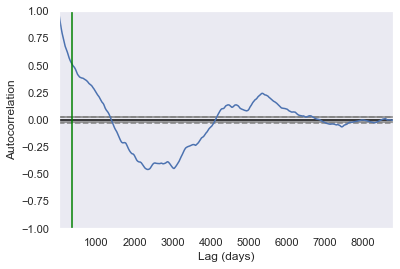

In [62]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(oil['Log_Error_Exponential'])
plt.xlabel('Lag (days)')
plt.axvline(365, color = 'green');

Notice that the autocorrelation is one at zero lag. This will be true for every time series. Why? Also notice that the autocorrelation drops to zero at around 1500 days. We have discovered that if we want to predict future oil values, we should only consider "noise" up until 1500 days prior. The time associated with this zero crossing is called the characteristic time scale.


#### Seasonality


The autocorrelation can also reveal seasonality.  Here, the autocorrelation of the temperature data shows yearly peaks that indicate the yearly cycles.

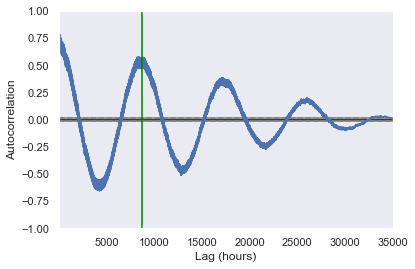

In [63]:
# Let's plot a few years of data
f = plt.figure()
ax = autocorrelation_plot(temps.Temperature[:365*24*4])
plt.xlabel('Lag (hours)')
plt.axvline(365*24, color = 'green');

If we zoom in to the short-time region, we can see several other patterns.  What is responsible for these?

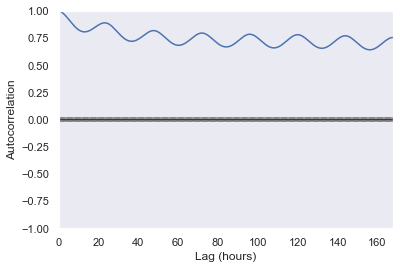

In [64]:
ax.set_xlim(0, 24*7)
f

While Fourier transforms are very good for detecting seasonality in truly periodic data, autocorrelations can be very helpful in detecting transient cyclic patterns, whose phase may not be consistent over time.


### Moving Average


Once we know how closely points in the time series are correlated with recent points, we can predict arbitrarily far into the future by substituting the moving average predictions in for values as necessary. For example, if we only knew the values up through time x, we would need to estimate Value[x + 1] before calculating Value[x + 2] = f(Value[x + 1], Value[x], Value[x - 1], ...).

There are many types of [moving average](http://en.wikipedia.org/wiki/Moving_average). Simple variations on this include [exponential moving averages](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) and [rolling window averages](https://en.wikipedia.org/wiki/Moving_average#Cumulative_moving_average). While these features might give more accurate data, they are only useful for short-term projections (as compared to seasonality and longer-term trends). As you'll see, they're also quite good for smoothing purposes. We will be computing the exponentially weighted moving average here:

$$E_t = \alpha X_t + (1-\alpha)E_{t-1} \ \ \textrm{ where } 0 \leq \alpha \leq 1.$$

Note that as the smoothing factor $\alpha$ increases, older observations are discounted faster. In Pandas, the `ewm()` method allows for specifying the decay as a function of $\alpha$ in three ways:
1. The center of mass (*com*), giving $\alpha = \frac{1}{1 + com}$
2. The *span*, giving $\alpha = \frac{2}{1 + span}$
3. The *halflife*, giving $\alpha = 1 - \exp({\frac{\log(0.5)}{\textrm{halflife}}})$

### Example: Predicting Oil Prices


Let's pick up the oil price data using the residual after the exponential trend is removed. Since we know that something crazy happened in 2008 (financial meltdown) and something else crazy happened in 1992 (Iraq War), we'll restrict our analysis to between those two dates. We will attempt to build a model to predict oil prices 3 months in the future.  A column of oil prices shifted by in time by 3 months will serve as our labels for testing and training.

In [65]:
## Create a column with "true" (future) values
PERIOD_MONTH = 20  #  prices are only recorded on "business days"
PREDICTION_LAG = 3 * PERIOD_MONTH

CUT_YEAR = 2008

# Notice that the goal (what we want to predict) is the oil price shifted by the desired period of time.
oil['Actual'] = oil['Value'].shift(-PREDICTION_LAG)

oil.head()

,Value,Julian,const,Exponential_Model,Log_Error_Exponential,Actual
Date,,,,,,
1986-01-02,25.56,2446432.5,1.0,14.660441,0.555876,10.25
1986-01-03,26.00,2446433.5,1.0,14.662491,0.572804,11.13
1986-01-06,26.53,2446436.5,1.0,14.668642,0.592564,11.35
1986-01-07,25.85,2446437.5,1.0,14.670693,0.566459,11.70
1986-01-08,25.87,2446438.5,1.0,14.672745,0.567092,12.75


In [66]:
oil['Value'].head()

Date
1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
Name: Value, dtype: float64

In [67]:
oil['Value'].shift(-1).head()

Date
1986-01-02    26.00
1986-01-03    26.53
1986-01-06    25.85
1986-01-07    25.87
1986-01-08    26.03
Name: Value, dtype: float64

We build a model to predict the residuals of the exponential model three months out, from the last and current residuals, as well as 3-month rolling averages for the price and its derivative.

In [68]:
### Cross validation -- simple model

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]

# Reporting function
def summarize_errors(test_me):
    error_pct = (test_me['Actual'] - test_me['Model']) / test_me['Actual']

    print(error_pct.describe())
    error_pct.plot()
    plt.title('% error')
    plt.show()

    error_pct.hist(bins=100, density=True, label = 'Counts')
    x = np.arange(-1, 1, 0.001)
    plt.plot(x, sp.stats.norm(loc=error_pct.mean(),
                              scale=error_pct.std()).pdf(x),
                              linewidth=3, color='red', label='Normal Dist')
    plt.title('Histogram of % errors')
    plt.legend()
    plt.show()

    print(sklearn.metrics.mean_squared_error(test_me['Actual'], test_me['Model']))

# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['LEE_1'] = frame['Log_Error_Exponential'].shift(1)
    feats['dLEE_avg'] = pd.Series.rolling(frame['Value'].diff(), window=3*PERIOD_MONTH).mean()
    feats['vol_avg'] = pd.Series.ewm(frame['Value'], span=3*PERIOD_MONTH).var(bias=False)
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return add_constant(feats)

In [69]:
feats = frame_to_feats(train).dropna(how='any')
X_train = feats.drop('Actual_LEE', axis=1).values
y_train = feats['Actual_LEE'].values
regress = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

feats, regress

(                 LEE     LEE_1  dLEE_avg    vol_avg  Actual_LEE  const
 Date                                                                  
 1986-03-31 -0.370179 -0.267680 -0.255167  14.707475   -0.071713    1.0
 1986-04-01 -0.287952 -0.370179 -0.247833  14.679926   -0.126994    1.0
 1986-04-02 -0.268518 -0.287952 -0.253000  14.557953   -0.133960    1.0
 1986-04-03 -0.238287 -0.268518 -0.235833  14.330118   -0.115999    1.0
 1986-04-04 -0.152485 -0.238287 -0.218667  13.912574   -0.160735    1.0
 ...              ...       ...       ...        ...         ...    ...
 2007-09-28  0.607166  0.622139  0.163833  33.022778    0.735978    1.0
 2007-10-01  0.590322  0.607166  0.125167  32.703464    0.755605    1.0
 2007-10-02  0.586314  0.590322  0.131000  32.254389    0.763153    1.0
 2007-10-03  0.585799  0.586314  0.119500  31.771646    0.756784    1.0
 2007-10-04  0.604366  0.585799  0.148333  31.738875    0.755531    1.0
 
 [5431 rows x 6 columns],
 LinearRegression())

In [70]:
# Predict
feats = frame_to_feats(test).dropna(how='any')
X_test = feats.drop('Actual_LEE', axis=1).values
y_test = feats['Actual_LEE'].values
feats['Predicted_LEE'] = regress.predict(X_test)

feats

,LEE,LEE_1,dLEE_avg,vol_avg,Actual_LEE,const,Predicted_LEE
Date,,,,,,,
2008-03-31,0.799434,0.838964,0.031667,42.795661,1.083348,1.0,0.738019
2008-04-01,0.793169,0.799434,0.029167,41.181751,1.064199,1.0,0.725674
2008-04-02,0.831041,0.793169,0.115500,40.230716,1.100643,1.0,0.747593
2008-04-03,0.822183,0.831041,0.147333,39.048825,1.106103,1.0,0.747044
2008-04-04,0.842709,0.822183,0.161000,38.515429,1.107614,1.0,0.759151
...,...,...,...,...,...,...,...
2020-08-12,-0.700714,-0.726013,0.171667,43.845206,-0.812238,1.0,-0.625218
2020-08-13,-0.708868,-0.700714,0.145000,42.829872,-0.854486,1.0,-0.625374
2020-08-14,-0.713989,-0.708868,0.129167,41.774616,-0.774884,1.0,-0.630230


In [71]:
test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Simple_Model'] = np.exp(test['Predicted_LEE']) * test['Exponential_Model']

test

,LEE,LEE_1,dLEE_avg,vol_avg,Actual_LEE,const,Predicted_LEE,Value,Julian,const_r,Exponential_Model,Log_Error_Exponential,Actual,Simple_Model
Date,,,,,,,,,,,,,,
2008-03-31,0.799434,0.838964,0.031667,42.795661,1.083348,1.0,0.738019,101.54,2454556.5,1.0,45.650710,0.799434,136.49,95.491576
2008-04-01,0.793169,0.799434,0.029167,41.181751,1.064199,1.0,0.725674,100.92,2454557.5,1.0,45.657093,0.793169,133.92,94.333169
2008-04-02,0.831041,0.793169,0.115500,40.230716,1.100643,1.0,0.747593,104.83,2454558.5,1.0,45.663477,0.831041,138.91,96.437152
2008-04-03,0.822183,0.831041,0.147333,39.048825,1.106103,1.0,0.747044,103.92,2454559.5,1.0,45.669862,0.822183,139.69,96.397707
2008-04-04,0.842709,0.822183,0.161000,38.515429,1.107614,1.0,0.759151,106.09,2454560.5,1.0,45.676248,0.842709,139.96,97.585537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,-0.700714,-0.726013,0.171667,43.845206,-0.812238,1.0,-0.625218,42.60,2459073.5,1.0,85.847176,-0.700714,38.56,45.940686
2020-08-13,-0.708868,-0.700714,0.145000,42.829872,-0.854486,1.0,-0.625374,42.26,2459074.5,1.0,85.859180,-0.708868,36.97,45.939944
2020-08-14,-0.713989,-0.708868,0.129167,41.774616,-0.774884,1.0,-0.630230,42.05,2459075.5,1.0,85.871185,-0.713989,40.05,45.723769


In [72]:
# Report
test_me = test[['Actual', 'Simple_Model']].dropna(how='any') \
                                          .rename(columns={'Simple_Model': 'Model'})
test_me

,Actual,Model
Date,,
2008-03-31,136.49,95.491576
2008-04-01,133.92,94.333169
2008-04-02,138.91,96.437152
2008-04-03,139.69,96.397707
2008-04-04,139.96,97.585537
...,...,...
2020-08-12,38.56,45.940686
2020-08-13,36.97,45.939944
2020-08-14,40.05,45.723769


count    3137.000000
mean       -0.069726
std         0.357564
min        -5.411939
25%        -0.110714
50%         0.014211
75%         0.102081
max         0.653470
dtype: float64


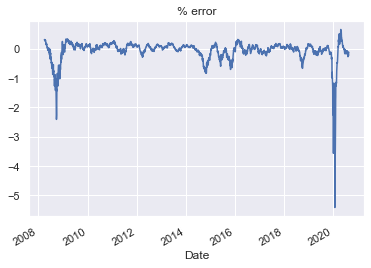

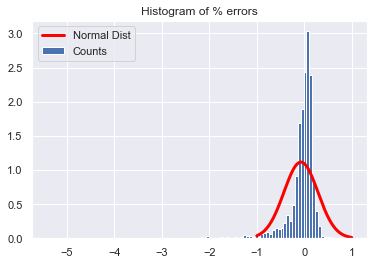

210.0027320796922


In [73]:
summarize_errors(test_me)

**Exercise**: Build a temperature predictor using just these other features.  Try experimenting with non-linear models like random forests as well as linear ones.  While it may not be as effective, it can add signal when combined with the above models.  *Notes*:
1. Make sure you don't accidentally give yourself access to concurrent data: you cannot use the wind direction this hour to predict the temperature, you have to use past wind direction information.
1. Try combining the signal using non-linear as well as linear techniques.  Is there a reason you might think that linear techniques work pretty well for aggregation of different signals?

## Using external data sources as features


So far, our features have all depended on the date and previous temperature.  However, we can add in other variables into our prediction. Ideally we'd like to find signal in additional data sources that accounts for some of the error; to try to conceptually explain sources of error or skews in the distribution of error; etc.  Here are examples of other data sources we might try:

  - Other financial indicators (e.g., interest rates, volatilities, related commodities)
  - Non-financial indicators (e.g., weather, indicators for weather patterns / wars, geopolitical data like GDELT (__[Global Database of Events, Language, and Tone](https://www.gdeltproject.org/)__)).
  
We'll show the example of trying to use natural gas futures contracts. Can you do better?

In [76]:
ng_fut = get_quandl("CHRIS/CME_NG1", authtoken)
# vix = get_quandl("CBOE/VIX", authtoken)
vix = get_quandl("CHRIS/CBOE_VX1", authtoken)

with open('small_data/quandl_ng_fut.pkl', 'wb') as f:
   dill.dump(ng_fut, f)  

with open("small_data/quandl_ng_fut.pkl", "rb") as fin:
    ng_fut = dill.load(fin)

oil['vix'] = vix['Close']
oil['ng_fut'] = ng_fut['Settle']


In [82]:
# Looking at linear correlations between new data and the stationary residual of the oil data
print(oil['Log_Error_Exponential'].corr(oil['vix']))  # Our error term does correlate negatively with vix...
print(oil['Log_Error_Exponential'].corr(oil['ng_fut']))

0.20746234523649085
0.5682360008407379


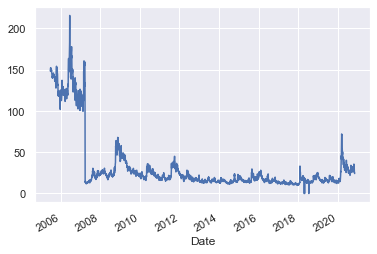

In [83]:
oil['vix'].plot()
plt.show()

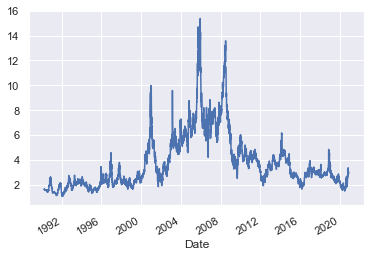

In [84]:
oil['ng_fut'].plot()
plt.show()

In [85]:
### Cross validation -- complex model -- notice that we have overfit!

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]


# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['dLEE_avg'] = pd.Series.rolling(frame['Value'].diff(), window=3*PERIOD_MONTH).mean()
    feats['vol_avg'] = pd.Series.ewm(frame['Value'], span=3*PERIOD_MONTH).var(bias=False)
    
    feats['ng_fut'] = frame['ng_fut']
    #feats['vix'] = frame['vix']
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return add_constant(feats)
    

feats = frame_to_feats(train).dropna(how='any')
regress = sklearn.linear_model.LinearRegression().fit( 
        X=feats.drop('Actual_LEE', axis=1), 
        y=feats['Actual_LEE'])

feats, regress

(                 LEE  dLEE_avg    vol_avg  ng_fut  Actual_LEE  const
 Date                                                                
 1990-04-03  0.105019 -0.033667   1.298413   1.635   -0.070426    1.0
 1990-04-04  0.082384 -0.052000   1.305354   1.620   -0.078161    1.0
 1990-04-05  0.066961 -0.061167   1.334966   1.615   -0.085053    1.0
 1990-04-06  0.049736 -0.067000   1.393297   1.625   -0.097667    1.0
 1990-04-09  0.005007 -0.067333   1.557477   1.637   -0.097807    1.0
 ...              ...       ...        ...     ...         ...    ...
 2007-09-28  0.607166  0.163833  33.022778   6.870    0.735978    1.0
 2007-10-01  0.590322  0.125167  32.703464   7.050    0.755605    1.0
 2007-10-02  0.586314  0.131000  32.254389   7.427    0.763153    1.0
 2007-10-03  0.585799  0.119500  31.771646   7.277    0.756784    1.0
 2007-10-04  0.604366  0.148333  31.738875   7.412    0.755531    1.0
 
 [4381 rows x 6 columns],
 LinearRegression())

In [86]:
# Predict

feats = frame_to_feats(test).dropna(how='any')
feats['Predicted_LEE'] = regress.predict(feats.drop('Actual_LEE', axis=1))

feats

,LEE,dLEE_avg,vol_avg,ng_fut,Actual_LEE,const,Predicted_LEE
Date,,,,,,,
2008-03-31,0.799434,0.031667,42.795661,10.101,1.083348,1.0,0.750188
2008-04-01,0.793169,0.029167,41.181751,9.724,1.064199,1.0,0.741767
2008-04-02,0.831041,0.115500,40.230716,9.832,1.100643,1.0,0.769769
2008-04-03,0.822183,0.147333,39.048825,9.417,1.106103,1.0,0.755308
2008-04-04,0.842709,0.161000,38.515429,9.322,1.107614,1.0,0.771548
...,...,...,...,...,...,...,...
2020-08-12,-0.700714,0.171667,43.845206,2.152,-0.812238,1.0,-0.678664
2020-08-13,-0.708868,0.145000,42.829872,2.182,-0.854486,1.0,-0.682377
2020-08-14,-0.713989,0.129167,41.774616,2.356,-0.774884,1.0,-0.682626


In [87]:
test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Complex_Model'] = np.exp (test['Predicted_LEE']) * test['Exponential_Model']

test

,LEE,dLEE_avg,vol_avg,ng_fut,Actual_LEE,const,Predicted_LEE,Value,Julian,const_r,Exponential_Model,Log_Error_Exponential,Actual,vix,ng_fut_r,Complex_Model
Date,,,,,,,,,,,,,,,,
2008-03-31,0.799434,0.031667,42.795661,10.101,1.083348,1.0,0.750188,101.54,2454556.5,1.0,45.650710,0.799434,136.49,25.92,10.101,96.660718
2008-04-01,0.793169,0.029167,41.181751,9.724,1.064199,1.0,0.741767,100.92,2454557.5,1.0,45.657093,0.793169,133.92,24.00,9.724,95.863596
2008-04-02,0.831041,0.115500,40.230716,9.832,1.100643,1.0,0.769769,104.83,2454558.5,1.0,45.663477,0.831041,138.91,24.64,9.832,98.599699
2008-04-03,0.822183,0.147333,39.048825,9.417,1.106103,1.0,0.755308,103.92,2454559.5,1.0,45.669862,0.822183,139.69,24.25,9.417,97.197702
2008-04-04,0.842709,0.161000,38.515429,9.322,1.107614,1.0,0.771548,106.09,2454560.5,1.0,45.676248,0.842709,139.96,24.00,9.322,98.802851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,-0.700714,0.171667,43.845206,2.152,-0.812238,1.0,-0.678664,42.60,2459073.5,1.0,85.847176,-0.700714,38.56,23.35,2.152,43.549775
2020-08-13,-0.708868,0.145000,42.829872,2.182,-0.854486,1.0,-0.682377,42.26,2459074.5,1.0,85.859180,-0.708868,36.97,23.20,2.182,43.394437
2020-08-14,-0.713989,0.129167,41.774616,2.356,-0.774884,1.0,-0.682626,42.05,2459075.5,1.0,85.871185,-0.713989,40.05,23.29,2.356,43.389704


In [88]:
# Report
test_me = test[['Actual', 'Complex_Model']].dropna(how='any') \
                                           .rename(columns = {'Complex_Model': 'Model'})

test_me

,Actual,Model
Date,,
2008-03-31,136.49,96.660718
2008-04-01,133.92,95.863596
2008-04-02,138.91,98.599699
2008-04-03,139.69,97.197702
2008-04-04,139.96,98.802851
...,...,...
2020-08-12,38.56,43.549775
2020-08-13,36.97,43.394437
2020-08-14,40.05,43.389704


count    3094.000000
mean       -0.015270
std         0.338812
min        -5.277557
25%        -0.073258
50%         0.049622
75%         0.138620
max         0.758314
dtype: float64


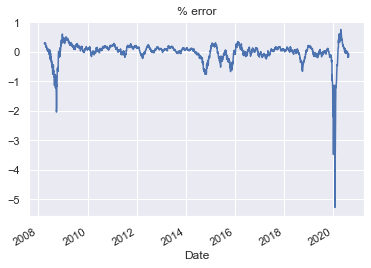

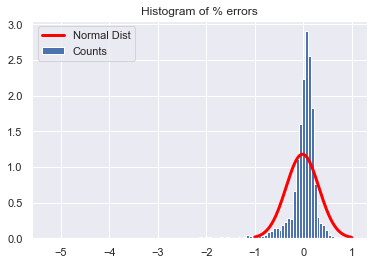

198.97380750385804


In [89]:
summarize_errors(test_me)

### Open-ended brainstorming / exercises


1. What happens to the results above if we change our "cut point" to say 2010?  What's the moral of this story...

2. Play around with the previous "Complex" model, and see if you can improve it.  What happens, for instance, if you get rid of the 'VIX' signal.  Why do you think this might be the case?

3. What are some other "simplest" models we could have tried? e .g., linear regression just on 'Value' rather than going through this log stuff.  Try some of them -- how do they perform?

4. Carry out a similar analysis for the temperature data.

## More advanced time series modeling frameworks

If a time series can be made stationary (trendless) by differencing or by the methods above, it is common to model it using some combination of auto-regressive terms (weighted average over some recent values) and moving average terms (weighted average over some recent errors) of different orders. The number of terms can be determined through various methods and rules of thumb. [Read more.](http://people.duke.edu/~rnau/411arim.htm)

There is an entire literature on [auto-regressive models](https://en.wikipedia.org/wiki/Autoregressive_model) as well as [auto-regressive moving average models](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model).  Read up about them on Wikipedia to get a better idea.  In python, they are implemented in [`Statsmodels`](https://github.com/statsmodels/statsmodels/).

* **Moving Average (MA) model**. This model works under the assumption that the output variable depends linearly on the current and past values of noise. 
$$ X_t = \mu + \varepsilon_t + \sum_{s=1}^q \theta_s \varepsilon_{t-s} $$

Here, $\mu$ is the mean of the time series, the $\varepsilon$'s are the noise, and the $\theta$'s are the model parameters. We choose $q$ based on the where the autocorrelation function of MA($q$) becomes zero at lag $q+1$. We can fit the model parameters $\theta$ using least squares regression or maximum likelihood estimation. 

* **Auto-regressive Model (AR)**.  Informally, auto-regressive processes "regress to the mean".  This model works under the assumption that the output depends linearly on the previous values and a stochastic term. 

$$ X_t = c + \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t $$

Here, $c$ is a constant and the $\varphi$'s are the model parameters. The parameters can be found using least squares regression, maximum likelihood estimation, or the autocorrelation function:

$$ \rho(\tau) = \sum_{s=1}^p \varphi_s \rho(s - \tau) $$
  
* **ARMA**.  This is just a combination of auto-regressive and moving average structures.  An $ARMA(p,q)$ process is given by the equations
$$ X_t = \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t + \sum_{s=1}^q \theta_s \varepsilon_{t-s} $$
Because we like mathematical shorthand, we will define a "lag operator" as
$$ L(X)_t = X_{t-1} $$
so that $L^2(X)_t = X_{t-2}$, etc ...
Then we can rewrite the ARMA equation in terms of the lag operator as
$$ \varphi(L) X = \theta(L) \epsilon $$
where the polynomials are given by 
$$\varphi(z) = 1-\sum_{r=1}^p \varphi_r z^r$$
and
$$\theta(z) = 1+\sum_{s=1}^q\theta_s z^s \, .$$  It turns out this fancy notation will be useful later on. You can use a 2-step regression to estimate the model parameters. Alternatively you can use maximum likelihood estimation or Yule-Walker estimation. 

* **ARIMA**.  While ARMA is useful for handling stationary processes, it does not handle non-stationary processes well.  Sometimes we can remove drift and seasonality directly, especially when there is a clear physical interpretation.  Other times, it is easier to just do so automatically by "differentiating".  We'll define the operator $\nabla= (1-L)$ so that
$$ (\nabla X)_t = X_t - X_{t-1} $$
Notice that
$$ (\nabla^2 X)_t = (1-L)^2  X_t = (1-2L+L^2)X_t = X_t - 2X_{t-1} + X_{t-2}. $$
$ARIMA(p, d, q)$ is just $ARMA(p,q)$ applied to $(\nabla^d X)_t$.  In our operator notation
$$ (\varphi \circ \nabla^d) (L) X = \theta (L) \varepsilon\,. $$
Notice that we can just rewrite $\varphi' = \varphi \circ \nabla^d$ as
$$ \varphi'(z) = 1- \sum_{r=1}^{p+d} \varphi'_r z^r = \left(1-\sum_{r=1}^p \varphi_r z^r\right) (1-z)^d $$
and so we have that $ARIMA(p, d, q)$ is (basically) just an $ARMA(p+d,q)$.

**Exercise**: Write a *residual regressor* that takes your best model and tries to fit and AR or ARMA model on the residuals using `Statsmodels`.  *Notes:*
1.  We should always first remove seasonality and "last data point" features (the low-hanging fruit) before trying to perform analysis on the residuals.
1.  It is not always natural to fit `Statsmodels` into the framework
1.  While the previous models could be tested by training models on the entire training set and then validating, for these autocorrelation models, we have to use sliding-window validation method mentioned above.

### Stochastic auto-regressive models


Our time series has, very clearly, time-varying volatility.  To accurately model these effects, one often uses stochastic models.  To start you Googling, the basic auto-regressive examples are **ARCH/GARCH**.  

Let us say just a little about these, leaving an example as an exercise to the reader.  In this type of model, the next time tick's value is drawn from a _distribution_ whose mean **and** standard deviation are modeled over time (and can, in general, be auto-regressive):

$$ t_{i+1} = M(\text{..factors..}) + \sigma(\text{..factors..}) \epsilon_t $$

where 
  - $M$ is some model for the mean (e.g., a linear model depending on some number of time lags of $t_{i}$ and moving averages in GARCH models);
  - $\sigma$ is some model for the standard deviation (as above in GARCH);
  - and, $\epsilon_t$ is a draw from a distribution having (conditional on the factors..) mean equal to zero, and standard deviation equal to one.  (In ARCH, this is a normal distribution.)
  
Stochastic models allow us to generate a range of future paths, for instance for modeling "value at risk."

### Exit Tickets

1. Describe how you would cross-validate a time series model.
1. Describe the difference between auto-regressive and moving average terms in an ARMA model.
1. Explain an FFT to a layperson.

*Copyright &copy; 2020 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*